# Do qpAdm Analysis for Punic Individuals based on overall model
Spain IA + Mycenean + Algeria IA

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
os.sys.path.append(path)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


# 0) Import qpAdm and set defintions

In [2]:
from python.run_qpadm import qpAdm_run, get_meta_ind_table, modifiy_iid_files, set_iids_to_label
from python.plot_qpadm import plot_qpadm, plot_qpadm_split

### Parameters for qpAdm_run are set there!
a12 = ["Mota", "Ust_Ishim", "Kostenki14", "GoyetQ116-1", "Vestonice16", "MA1",
           "ElMiron", "Villabruna", "EHG", "CHG", "Natufian",
           "Levant_N"] # List of ancient European populations for right populations
distal = ["Anatolia_N", "WHG", "Steppe_EMBA", 
          "Iran_N", "Morocco_EN.SG"]
print(f"# Anc_Euro: {len(a12)} populations")
print(f"# Distal sources: {len(distal)} populations")

# Anc_Euro: 12 populations
# Distal sources: 5 populations


## 1) Prepare .ind File

### Optional: Screen for Labels

In [3]:
vrs = "49.2"
df = get_meta_ind_table(path_ind = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind",
                        path_anno = f"/n/groups/reich/hringbauer/Data/v{vrs}.anno.csv",
                        min_snp = 30000)
### Screen for what one wants
df[df["clst"].str.contains("Levant_N")]["clst"].value_counts()

Filtering to 1137/1142
Loaded 1137 Individuals
Filtered to 1091 Individuals based on #SNP covered> 30000
Filtered to 1002 Individuals based on duplicates.


Levant_N    12
Name: clst, dtype: int64

### Prepare .ind File with Punic Indivdiuals clustered out

In [4]:
### Populations to overwrite. Typically because they have the ".SG" label
ind_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"          # What .ind to load
df_lbs = pd.read_csv("./data/cluster_assignments_punic.v49.2.tsv", sep="\t")  ### Load external Label file (Google docs)

ind_modified = f"./eigenstrat/anc_only.v{vrs}.punic_early_ind.ind"    # Where to save the modified version to

df_ind = pd.read_csv(ind_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

### Reset Clusters
for _, row in df_lbs.iterrows():
    iid = row['iid']
    
    idx = df_ind["iid"] == iid
    if np.sum(idx)<1:
        print(f"Warning, {iid} not found in {vrs} .ind file.")
    
    df_ind.loc[idx, "clst"] = iid
    ### Reset All the Individuals in the Target Ind
    #df_ind = set_iids_to_clst(df_ind, iids=iids, clst=g, savepath="")
 
# Save individuals
df_ind.to_csv(ind_modified, header=False, sep=" ", index=False)
print(f"Saved updated {len(df_ind)} IIDs to: {ind_modified}")

Loaded 1142 Individuals
Warning, I26842 not found in 49.2 .ind file.
Saved updated 1142 IIDs to: ./eigenstrat/anc_only.v49.2.punic_early_ind.ind


# 2) Run Indivdiual qpAdm analysis

### a) Extract IIDs to run
Start with all indivdiuals from Punic Early cluster

In [5]:
df_early = df_lbs[df_lbs["label"]=="Punic_Early"]
print(f"Found {len(df_early)} Punic_Early indivdiuals")
iids = df_early["iid"].values

Found 17 Punic_Early indivdiuals


In [20]:
%%time

### Test Run for single Indivdiual
target = iids[0]
sources = ["Algeria_IA", "Greece_BA_Mycenaean", "Spain_IA"]  # Flip last component with down
rightpops = a12 + ["Morocco_EN.SG", "Iran_N"] # Flip last component with up

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early_ind",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 76.659356
CPU times: user 7.03 ms, sys: 7.53 ms, total: 14.6 ms
Wall time: 1min 16s


0

In [21]:
for iid in iids:
    target = iid
    sources = ["Algeria_IA", "Greece_BA_Mycenaean", "Spain_IA"]  # Flip last component with down
    rightpops = a12 + ["Morocco_EN.SG", "Iran_N"] # Flip last component with up

    leftpops = [target] + sources
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops), 
              input_folder = "./eigenstrat/", 
              input_file = "anc_only.v49.2",
              input_ind_suff = ".punic_early_ind",
              par_file_folder = "./parfiles/", 
              output_folder = "./output/qpAdm/v49.2/early_punic_proxi_ind/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=False)

Runtime: 74.878909
Runtime: 76.503767
Runtime: 74.638568
Runtime: 75.984197
Runtime: 74.294235
Runtime: 75.049619
Runtime: 74.728379
Runtime: 75.132715
Runtime: 74.545568
Runtime: 76.380574
Runtime: 74.653284
Runtime: 77.015095
Runtime: 75.474888
Runtime: 75.088598
Runtime: 76.629949
Runtime: 75.920076
Runtime: 94.559649


# 3) Plot qpAdm Models

### 3a) Visualize all individual 3-way models of all early Punic individuals in cluster
Interpretation:
Highly heterogenous Cluster - Ongoing Mixing - Not one population. Clear Traces of North African Ancestry.


Found 17 Punic_Early indivdiuals


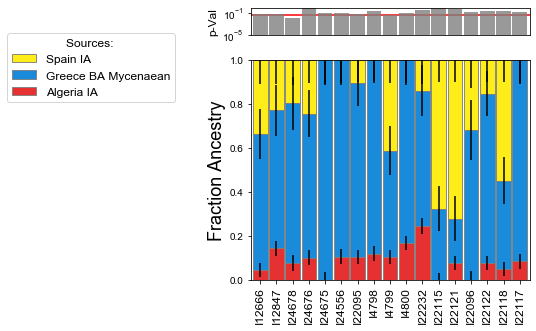

In [5]:
### Load IIDS to plot
df_early = df_lbs[df_lbs["label"]=="Punic_Early"]
print(f"Found {len(df_early)} Punic_Early indivdiuals")
targets = df_early["iid"].values
sources = ["Algeria_IA", "Greece_BA_Mycenaean", "Spain_IA"]

paths = [".".join([t]+sources) for t in targets]

dir_path = f"./output/qpAdm/v49.2/early_punic_proxi_ind/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#e41a1c", "#007ED6", "#FFEC00"] # "#984ea3", "gray"

xlabels = [t.replace("_", " ") for t in targets]
labels = [s.replace("_", " ") for s in sources]

plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=False, labels=labels,
           best=True, pval_lim = [1e-5,1], figsize=(5,5), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.25, 1.15))

# Plot split up by site
The aim of this plot is to have better visualization per site

Found 17 Punic_Early indivdiuals


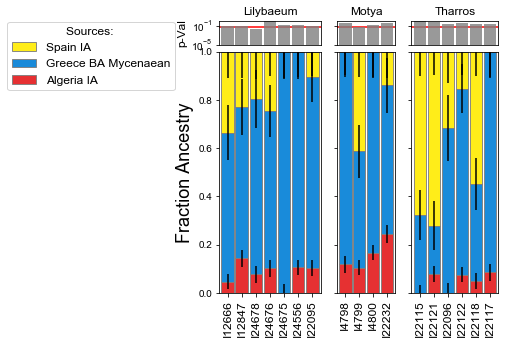

In [56]:
### Load IIDs to plot
df_early = df_lbs[df_lbs["label"]=="Punic_Early"]
print(f"Found {len(df_early)} Punic_Early indivdiuals")


sites = ["Lilybaeum", "Motya", "Tharros"]
iids = [df_early[df_early["label_fine"].str.contains(s)]["iid"].values for s in sites]
sources = ["Algeria_IA", "Greece_BA_Mycenaean", "Spain_IA"]
paths = [[".".join([t] + sources) for t in ls] for ls in iids]


dir_path = f"./output/qpAdm/v49.2/early_punic_proxi_ind/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#e41a1c", "#007ED6", "#FFEC00"] # "#984ea3", "gray"

xlabels = [t.replace("_", " ") for t in targets]
labels = [s.replace("_", " ") for s in sources]

plot_qpadm_split(dir_path=dir_path, test_pops=paths, save_path=save_path,
           labels_source=labels, labels_site=sites,
           best=True, pval_lim = [1e-5,1], figsize=(5,5), bw=0.9, lw=1.5, wspace=0.2,
           fs=12, c=c, ec="gray", l_pos=(-0.38, 1.15))

# Area 51